<div style='background-image: url("main.png") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 200px ; width: 100%'>
    <div style="float: right ; margin: 20px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.9) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , .8) ; line-height: 100%">Cinétique Chimique
            </div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Lois de vitesse | Reconnaître l'ordre d'une réaction
             </div>
        </div>
    </div>
</div>

In [1]:
# commande permettant d'insérer les figures matplotlib dans les notebooks
%matplotlib inline

# import des librairies 
import numpy as np
from scipy.integrate import odeint
from scipy import fft
import matplotlib.pyplot as plt

# Mise en œuvre du problème physique : lois de vitesse
## Problème physique à résoudre
On récupère les données cinétiques de la dismutation de l'eau oxygénée $\text{H}_2\text{O}_{2\text{(aq)}}$ fournies par le sujet Banque PT 2018 B.
$$\text{H}_2 \text{O}_{2\text{(aq)}} \to \text{H}_2 \text{O}_\text{(liq)} + \frac{1}{2}\text{O}_{2\text{(g)}}$$

&nbsp;

|$t$ (min)|0|5|10|20|30|35|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|C (mmol/L)|73|53|42|24|12|09

&nbsp;
Ces données sont stockées dans deux `array` : 
* `t` qui correspond aux instants où la concentration en eau oxygénée est mesurée ;
* `C` qui correspond aux valeurs de concentration correspondantes.

&nbsp;
On y ajoute les incertitudes-types associées à chaque grandeur et basées sur la précision avec laquelle sont spécifiées les valeurs.

In [2]:
# Données propres au système
t = 60*np.array([0,5,10,20,30,35]) # conversion en s
t_u = np.array(6*[1])
C = np.array([73e-3, 53e-3, 42e-3, 24e-3, 12e-3, 9e-3])
C_u = np.array(6*[.5e-3])

## Test d'une loi d'ordre 0
Si la réaction vérifie une cinétique d'ordre 0, il vient :

$$C=C_0-kt$$

&nbsp;
On peut tester cette loi en utilisant la méthode `polyfit` (<a href="https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html">doc.</a>) de `numpy` qui permet de trouver la droite présentant le meilleur accord possible avec les données expérimentales. 

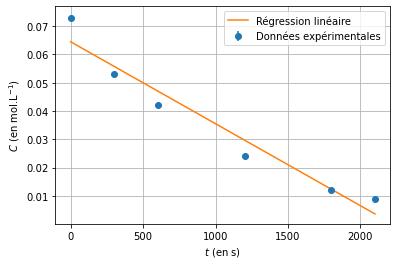

In [3]:
a,b=np.polyfit(t,C,1)

time = np.linspace(np.min(t), np.max(t), 1000)

# Tracé du signal en fonction du temps
plt.figure()
plt.errorbar(t, C, yerr = C_u, fmt='o' ,label="Données expérimentales")
plt.plot(time, a*time+b, label="Régression linéaire")
plt.grid(True)
plt.legend()
plt.xlabel(r'$t$ (en s)')
plt.ylabel(r'$C$ (en mol.L$^{-1}$)')
plt.show()  

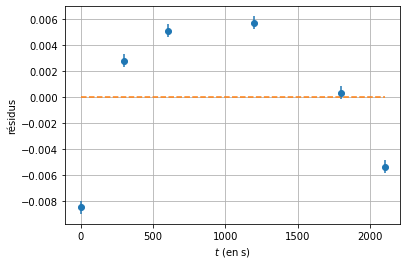

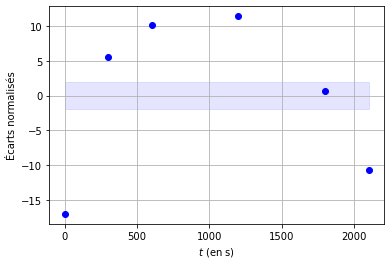

In [4]:
C_mod=a*t+b # on calcule les valeurs de C si la cinétique d'ordre 0 est vérifiée
res = C_mod-C  # on teste l'écart sur C entre données modélisées et expérimentales
En = res/C_u # on calcule le z-score

plt.figure()
plt.errorbar(t, res, yerr = C_u, fmt = 'o') # résidus avec barres d'incertitude-type
plt.plot([np.min(t), np.max(t)], [0, 0], '--') # pour mieux visualiser la droite correspondant à un résidu nul
plt.xlabel(r"$t$ (en s)")
plt.ylabel("résidus")
plt.grid()

plt.figure()
plt.plot(t, En, 'bo')             # écarts normalisés
plt.fill_between([np.min(t), np.max(t)], y1 = -2, y2 = 2, color = 'blue', alpha = .1)    # pour mieux visualiser le domaine des En acceptables
plt.xlabel(r'$t$ (en s)')
plt.ylabel("Écarts normalisés")
plt.grid()
plt.show()

Les points expérimentaux et la courbe ne concordent pas, les résidus ne sont pas répartis de manière aléatoire autour de la valeur 0 et le z-score est largement supérieur à 2 pour tout un ensemble de valeurs.

&nbsp;
L'ordre 0 peut vraisemblablement être rejeté.

## Test d'une loi d'ordre 1
Si la réaction vérifie une cinétique d'ordre 1, il vient :

$$\ln C=\ln C_0-kt$$

&nbsp;
On peut tester cette loi en utilisant la méthode `polyfit` (<a href="https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html">doc.</a>) de `numpy` qui permet de trouver la droite présentant le meilleur accord possible avec les données expérimentales. 

&nbsp;
On commence par créer l'`array` contenant $\ln C$ que l'on note `lnC`. On en profite pour évaluer l'incertitude-type sur cette grandeur en utilisant une méthode de MonteCarlo, avec une loi de distribution uniforme. L'écart-type ainsi calculé est noté `lnC_u`.

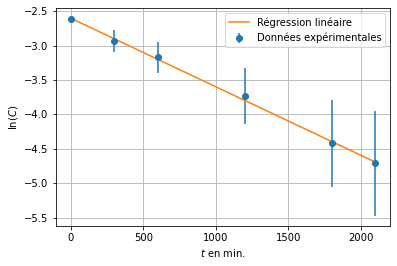

In [5]:
lnC = np.log(C)
lnC_u = []
C_mod=[]
for i in range(len(C)) :
    for j in range(100000):
        C_mod.append(C[i]+C_u[i]*np.random.uniform(-1,1))
    lnC_u.append(np.std(np.log(np.array(C_mod)), ddof=1))

a,b=np.polyfit(t,lnC,1)

time = np.linspace(np.min(t), np.max(t), 1000)

# Tracé du signal en fonction du temps
plt.figure()
plt.errorbar(t, lnC, yerr = lnC_u, fmt='o' ,label="Données expérimentales")
plt.plot(time, a*time+b, label="Régression linéaire")
plt.grid(True)
plt.legend()
plt.xlabel(r'$t$ en min.')
plt.ylabel(r'$\ln(C)$')
plt.show()  

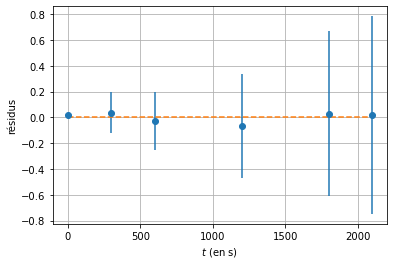

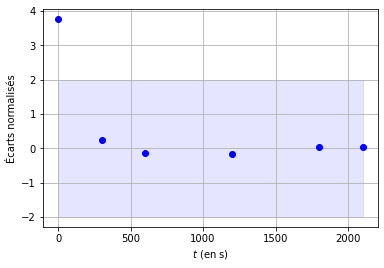

In [6]:
lnC_mod=a*t+b # on calcule les valeurs de lnC si la cinétique d'ordre 1 est vérifiée
res = lnC_mod-lnC # on teste l'écart sur C entre données modélisées et expérimentales
En = res/lnC_u # on calcule le z-score

plt.figure()
plt.errorbar(t, res, yerr = lnC_u, fmt = 'o') # résidus avec barres d'incertitude-type
plt.plot([np.min(t), np.max(t)], [0, 0], '--') # pour mieux visualiser la droite correspondant à un résidu nul
plt.xlabel(r"$t$ (en s)")
plt.ylabel("résidus")
plt.grid()

plt.figure()
plt.plot(t, En, 'bo')             # écarts normalisés
plt.fill_between([np.min(t), np.max(t)], y1 = -2, y2 = 2, color = 'blue', alpha = .1)    # pour mieux visualiser le domaine des En acceptables
plt.xlabel(r'$t$ (en s)')
plt.ylabel("Écarts normalisés")
plt.grid()
plt.show()

À l'exception du point mesuré à l'instant $t=0$, la droite tracée est visuellement compatible avec les données expérimentales et leurs barres d'incertitude. Les résidus sont placés de part et d'autre de la valeur 0 d'une façon qui semble aléatoire, et le z-score est nettement plus petit que 2.

&nbsp;
L'ordre 1 semble être un ordre possible pour la réaction étudiée.

## Test d'une loi d'ordre 2
Si la réaction vérifie une cinétique d'ordre 2, il vient :

$$\dfrac{1}{C}=\dfrac{1}{C_0}+kt$$

&nbsp;
On peut tester cette loi en utilisant la méthode `polyfit` (<a href="https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html">doc.</a>) de `numpy` qui permet de trouver la droite présentant le meilleur accord possible avec les données expérimentales. 

&nbsp;
On commence par créer l'`array` contenant $\dfrac{1}{C}$ que l'on note `invC`. On en profite pour évaluer l'incertitude-type sur cette grandeur en utilisant une méthode de MonteCarlo, avec une loi de distribution uniforme. L'écart-type ainsi calculé est noté `invC_u`.

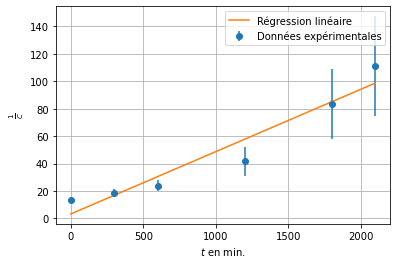

In [7]:
invC = 1/C
invC_u = []
C_mod=[]
for i in range(len(C)) :
    for j in range(100000):
        C_mod.append(C[i]+C_u[i]*np.random.uniform(-1,1))
    invC_u.append(np.std(1/np.array(C_mod), ddof=1))

a,b=np.polyfit(t,invC,1)

time = np.linspace(np.min(t), np.max(t), 1000)

# Tracé du signal en fonction du temps
plt.figure()
plt.errorbar(t, invC, yerr = invC_u, fmt='o' ,label="Données expérimentales")
plt.plot(time, a*time+b, label="Régression linéaire")
plt.grid(True)
plt.legend()
plt.xlabel(r'$t$ en min.')
plt.ylabel(r'$\frac{1}{C}$')
plt.show()  

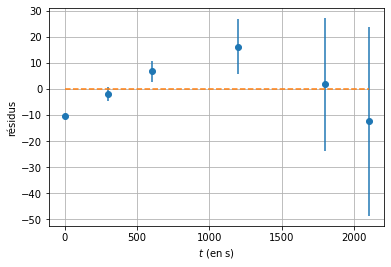

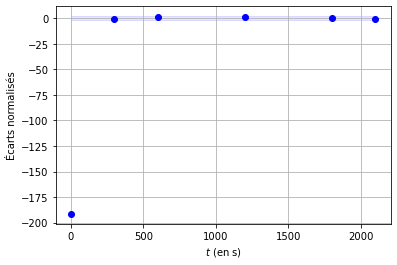

In [8]:
invC_mod=a*t+b # on calcule les valeurs de 1/C si la cinétique d'ordre 2 est vérifiée
res = invC_mod-invC # on teste l'écart sur C entre données modélisées et expérimentales
En = res/invC_u # on calcule le z-score
 

plt.figure()
plt.errorbar(t, res, yerr = invC_u, fmt = 'o') # résidus avec barres d'incertitude-type
plt.plot([np.min(t), np.max(t)], [0, 0], '--') # pour mieux visualiser la droite correspondant à un résidu nul
plt.xlabel(r"$t$ (en s)")
plt.ylabel("résidus")
plt.grid()

plt.figure()
plt.plot(t, En, 'bo')             # écarts normalisés
plt.fill_between([np.min(t), np.max(t)], y1 = -2, y2 = 2, color = 'blue', alpha = .1)    # pour mieux visualiser le domaine des En acceptables
plt.xlabel(r'$t$ (en s)')
plt.ylabel("Écarts normalisés")
plt.grid()
plt.show()

Visuellement, la droite tracée n'est pas vraiment compatible avec les données expérimentales et leurs barres d'incertitude. Les résidus et leur barre d'erreur ne se répartissent pas non plus aléatoirement autour de 0. Néanmoins, hormis pour le point à $t=0$, déjà problématique pour l'ordre 1, le z-score reste dans des valeurs acceptables, mais moins bonne pour que pour la cinétique d'ordre 1.

&nbsp;
On peut donc également écarter la loi cinétique d'ordre 2, et préférer l'ordre 1 pour décrire la réaction étudiée.

## Constante de vitesse
La loi cinétique d'ordre 1 étant validée, on peut utiliser ce modèle pour déterminer une valeur expérimentale de $k$ en calculant une moyenne selon une méthode de MonteCarlo.

In [9]:
lnCsurC0_moy = []
lnCsurC0_u = []
for i in range(len(C)) :
    CisurC0_mod=[]
    for j in range(100000):
        CisurC0_mod.append((C[i]+C_u[i]*np.random.uniform(-1,1))/(C[0]+C_u[0]*np.random.uniform(-1,1)))
    lnCsurC0_u.append(np.std(np.log(np.array(CisurC0_mod)), ddof=1))
    lnCsurC0_moy.append(np.mean(np.log(np.array(CisurC0_mod))))

k_moy=-np.mean(np.array((lnCsurC0_moy))[1:]/t[1:])
k_u=np.std(np.array((lnCsurC0_moy))[1:]/t[1:], ddof=1)

print("La constante de vitesse calculée est : ",format(k_moy,"#.2e"), "s^-1")
print("L'incertitude-type sur ce résultat est : ",format(k_u,"#.1e"), "s^-1")

La constante de vitesse calculée est :  9.83e-04 s^-1
L'incertitude-type sur ce résultat est :  6.0e-05 s^-1
